In [1]:
import csv
import itertools
import os
import re
from collections import Counter
from collections import defaultdict
from datetime import datetime
from datetime import timedelta
from string import punctuation

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.tslib import Timestamp

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 100
matplotlib.rcParams['lines.linewidth'] = 1.0

# Grupos

## Socios activos 2016

In [3]:
# 1.       CTA: categoría para niños y jóvenes hasta bachillerato
# 2.       CTI: categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)
# 3.       CTB: público general (solo permite préstamo de libros)
# 4.       CTC: público en general (permite préstamo de libros y material audiovisual)
# 5.       CTF: categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia
# 6.       CE1, CE2, CE2: categorías empresariales (solo para instituciones)
# 7.       CIS: categoría Inclusión Social
# 8.       CTU: categoría Universitaria
# 9.       VIP: Investigadores, préstamo de 30 materiales (libros y material audiovisual)

#      Categoría de lector: CE1 Categoría empresarial                                   218
#      Categoría de lector: CE2 Categoría empresarial 2                                   5
#      Categoría de lector: CEM Categoría Empleado/Pensionado                          1593
#      Categoría de lector: CIN Categoría Interbibliotecario                            128
#      Categoría de lector: CIP Categoría Investigador                                  351
#      Categoría de lector: CIS Categoría Inclusión Preferencial                      15974
#      Categoría de lector: CIV Categoría Investigadores                                 72
#      Categoría de lector: CML Categoría Mediador de Proyectos Culturales                2
#      Categoría de lector: CSU Categoría Sucursal                                       91
#      Categoría de lector: CTA Categoría Básica A                                    10610
#      Categoría de lector: CTB Categoría B                                            1359
#      Categoría de lector: CTC Categoría C                                             224
#      Categoría de lector: CTF Categoría familiar                                     1105
#      Categoría de lector: CTI Categoría Infantil                                     1004
#      Categoría de lector: CTU Categoría General                                     17402
#      Categoría de lector: PTE PROCESOS TÉCNICOS                                        95

In [4]:
%%time

dtypes = {
    'Sucursal': str,
    'Tratamiento': str,
    'Barrio': str,
    'Ciudad': str,
    'CATEG': str,
    'Ocupación1': str,
    'Nivel Estudio1': str,
    'Área de Estudio1': str,
    'Edad': 'category',
}

perfiles_df = pd.read_csv(
    'valores_grupos_2016.csv', header=0, dtype=dtypes)
# perfiles_df = perfiles_df.fillna('')

CPU times: user 61.9 ms, sys: 8.84 ms, total: 70.7 ms
Wall time: 69.9 ms


In [5]:
perfiles_df.shape

(50272, 9)

In [6]:
perfiles_df.head()

,Sucursal,Tratamiento,Barrio,Ciudad,CATEG,Ocupación1,Nivel Estudio1,Área de Estudio1,Edad
0,BLAA,OTRO,chapinero,bogota,CIN,universidad,OTRO,OTRO,OTRO
1,BLAA,sra.,OTRO,bogota,CEM,pensionado,OTRO,OTRO,51-64
2,BLAA,sra.,icata,bogota,CEM,empleado,profesional,filosofía y letras,OTRO
3,ARM,sr.,OTRO,OTRO,CEM,empleado,profesional,economía,51-64
4,BLAA,sr.,soledad,bogota,CEM,OTRO,OTRO,OTRO,OTRO


# Bogotá

In [7]:
perfiles_df = perfiles_df[perfiles_df['Ciudad'] == 'bogota']

In [8]:
perfiles_df.shape

(23496, 9)

In [9]:
perfiles_df.head()

,Sucursal,Tratamiento,Barrio,Ciudad,CATEG,Ocupación1,Nivel Estudio1,Área de Estudio1,Edad
0,BLAA,OTRO,chapinero,bogota,CIN,universidad,OTRO,OTRO,OTRO
1,BLAA,sra.,OTRO,bogota,CEM,pensionado,OTRO,OTRO,51-64
2,BLAA,sra.,icata,bogota,CEM,empleado,profesional,filosofía y letras,OTRO
4,BLAA,sr.,soledad,bogota,CEM,OTRO,OTRO,OTRO,OTRO
5,BLAA,OTRO,galerias,bogota,CIN,OTRO,OTRO,OTRO,OTRO


## Filtrando barrios

In [10]:
perfiles_df['Barrio'].nunique()

1601

In [11]:
%%time

cn = perfiles_df['Barrio'].value_counts()

def filter_barrio(x):
    e = x['Barrio']
    if e and cn[e] >= 200:
        r = e
    else:
        r = 'OTRO'
    return r

perfiles_df['Barrio'] = perfiles_df.apply(filter_barrio, axis=1)

CPU times: user 988 ms, sys: 4.67 ms, total: 992 ms
Wall time: 990 ms


In [12]:
perfiles_df['Barrio'].nunique()

8

## Nivel de estudios

In [13]:
columns = ['Tratamiento', 'Barrio', 'Nivel Estudio1', 'Edad']

In [14]:
combs = [
    ('Barrio', 'Nivel Estudio1'), # Nivel de estudio por barrio
    ('Tratamiento', 'Nivel Estudio1', 'Edad'), # Nivel de estudio por edad y sexo
    ('Barrio', 'Tratamiento', 'Nivel Estudio1', 'Edad'), # Nivel de estudio por barrio, edad y sexo
]

In [15]:
len(combs)

3

In [16]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = perfiles_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows() if 'OTRO' not in tuple(x)]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Barrio', 'Nivel Estudio1') 75
('Tratamiento', 'Nivel Estudio1', 'Edad') 122
('Barrio', 'Tratamiento', 'Nivel Estudio1', 'Edad') 311
CPU times: user 6.89 s, sys: 0 ns, total: 6.89 s
Wall time: 6.88 s


GROUP # 1
GROUP BY: ('Barrio', 'Nivel Estudio1')
NUMBER OF GROUPS: 75
TOP 12 LARGEST GROUPS:


,"(Barrio, Nivel Estudio1)",size,total,percentage
0,"(chapinero, profesional)",125,1592,7.85%
1,"(candelaria, profesional)",75,1592,4.71%
2,"(fontibon, universitario 2 nivel)",68,1592,4.27%
3,"(chapinero, universitario 2 nivel)",68,1592,4.27%
4,"(chapinero, universitario 1 nivel)",64,1592,4.02%
5,"(cedritos, profesional)",62,1592,3.89%
6,"(soledad, profesional)",61,1592,3.83%
7,"(castilla, universitario 1 nivel)",59,1592,3.71%
8,"(castilla, universitario 2 nivel)",59,1592,3.71%
9,"(fontibon, universitario 1 nivel)",56,1592,3.52%


GROUP # 2
GROUP BY: ('Barrio', 'Tratamiento', 'Nivel Estudio1', 'Edad')
NUMBER OF GROUPS: 311
TOP 12 LARGEST GROUPS:


,"(Barrio, Tratamiento, Nivel Estudio1, Edad)",size,total,percentage
0,"(soledad, sr., universitario 1 nivel, 16-30)",31,1401,2.21%
1,"(chapinero, sr., profesional, 31-40)",27,1401,1.93%
2,"(fontibon, sra., universitario 2 nivel, 16-30)",27,1401,1.93%
3,"(castilla, sra., universitario 1 nivel, 16-30)",26,1401,1.86%
4,"(chapinero, sra., universitario 1 nivel, 16-30)",25,1401,1.78%
5,"(fontibon, sra., universitario 1 nivel, 16-30)",25,1401,1.78%
6,"(chapinero, sr., universitario 1 nivel, 16-30)",25,1401,1.78%
7,"(castilla, sr., universitario 1 nivel, 16-30)",22,1401,1.57%
8,"(chapinero, sra., profesional, 31-40)",22,1401,1.57%
9,"(chapinero, sr., universitario 2 nivel, 16-30)",22,1401,1.57%


GROUP # 3
GROUP BY: ('Tratamiento', 'Nivel Estudio1', 'Edad')
NUMBER OF GROUPS: 122
TOP 12 LARGEST GROUPS:


,"(Tratamiento, Nivel Estudio1, Edad)",size,total,percentage
0,"(sra., universitario 1 nivel, 16-30)",2186,16948,12.90%
1,"(sr., universitario 1 nivel, 16-30)",2137,16948,12.61%
2,"(sra., universitario 2 nivel, 16-30)",1956,16948,11.54%
3,"(sr., universitario 2 nivel, 16-30)",1707,16948,10.07%
4,"(sr., profesional, 31-40)",747,16948,4.41%
5,"(sra., profesional, 31-40)",589,16948,3.48%
6,"(sra., profesional, 16-30)",491,16948,2.90%
7,"(sr., profesional, 51-64)",448,16948,2.64%
8,"(sr., universitario 2 nivel, 31-40)",438,16948,2.58%
9,"(sr., profesional, 41-50)",425,16948,2.51%


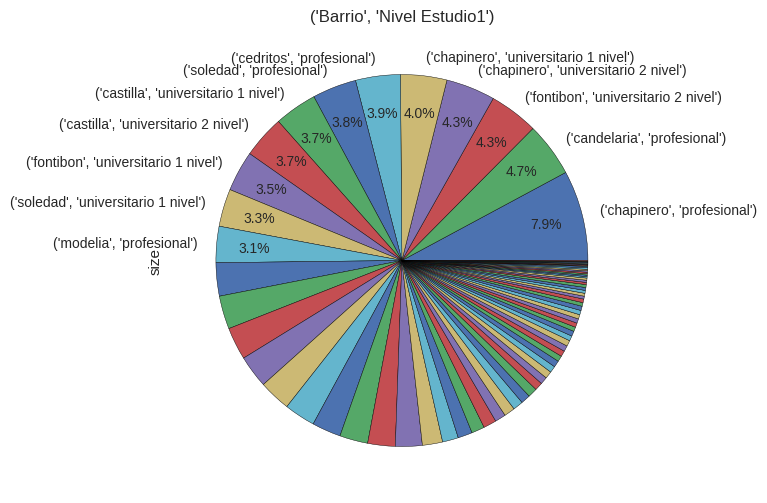

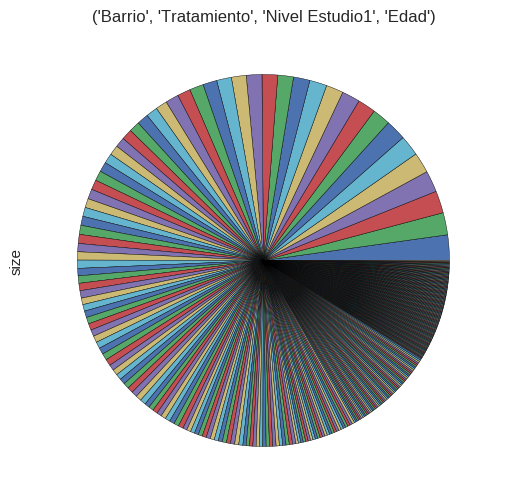

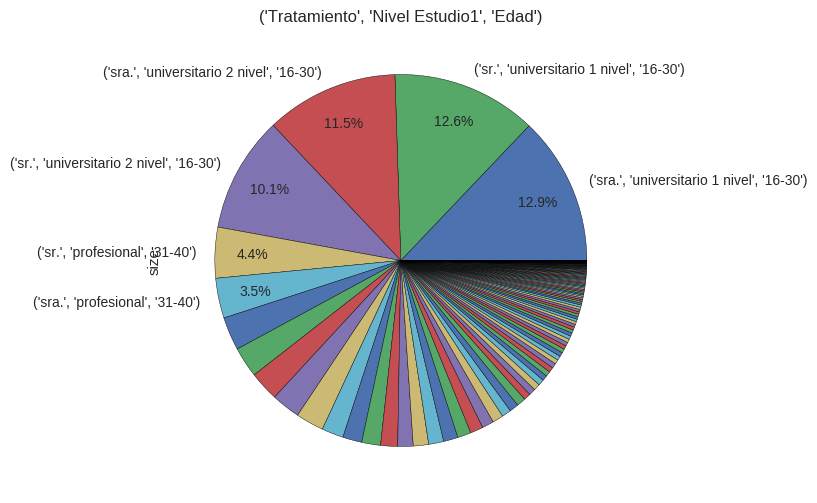

In [17]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('GROUP #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=k)